In [1]:
import os
import re
import emoji
import numpy as np
import unicodedata
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
##quita acentos,vuelve todo a minúsculas y se quitan signos 
def clean_text(text):
    res =  unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    res = re.sub("[^a-zA-Z0-9 ]"," ", res.decode("utf-8"), flags=re.UNICODE)
    res =  u' '.join(res.lower().split())
    return res

In [3]:
clean_text('¿Qué es eso    ?')

'que es eso'

In [4]:
from glob import glob

In [5]:
archivos_spam=glob('../data/SPAM/*.csv')

In [6]:
archivos_spam

['../data/SPAM/Youtube02-KatyPerry.csv',
 '../data/SPAM/Youtube03-LMFAO.csv',
 '../data/SPAM/Youtube05-Shakira.csv',
 '../data/SPAM/Youtube04-Eminem.csv',
 '../data/SPAM/Youtube01-Psy.csv']

In [7]:
archivos_spam[0].split('-')[1].split('.')[0]

'KatyPerry'

In [8]:
archivos_spam

['../data/SPAM/Youtube02-KatyPerry.csv',
 '../data/SPAM/Youtube03-LMFAO.csv',
 '../data/SPAM/Youtube05-Shakira.csv',
 '../data/SPAM/Youtube04-Eminem.csv',
 '../data/SPAM/Youtube01-Psy.csv']

In [9]:
data=[]
for file in archivos_spam:
    data_spam=pd.read_csv(file)
    data_spam['artista']=file.split('-')[1].split('.')[0]
    data.append(data_spam)

In [10]:
data_spam=pd.concat(data)

In [11]:
data_spam

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,artista
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free ...,1,KatyPerry
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-...,1,KatyPerry
2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1,KatyPerry
3,z13jcjuovxbwfr0ge04cev2ipsjdfdurwck,Aviel Haimov,2014-08-01T12:27:48,http://psnboss.com/?ref=2tGgp3pV6L this is the...,1,KatyPerry
4,z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k,John Bello,2014-08-01T21:04:03,Hey everyone. Watch this trailer!!!!!!!! http...,1,KatyPerry
...,...,...,...,...,...,...
345,z13th1q4yzihf1bll23qxzpjeujterydj,Carmen Racasanu,2014-11-14T13:27:52,How can this have 2 billion views when there's...,0,Psy
346,z13fcn1wfpb5e51xe04chdxakpzgchyaxzo0k,diego mogrovejo,2014-11-14T13:28:08,I don't now why I'm watching this in 2014﻿,0,Psy
347,z130zd5b3titudkoe04ccbeohojxuzppvbg,BlueYetiPlayz -Call Of Duty and More,2015-05-23T13:04:32,subscribe to me for call of duty vids and give...,1,Psy
348,z12he50arvrkivl5u04cctawgxzkjfsjcc4,Photo Editor,2015-06-05T14:14:48,hi guys please my android photo editor downloa...,1,Psy


In [12]:
data_spam.reset_index(drop=True,inplace=True)


In [13]:
data_spam

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,artista
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free ...,1,KatyPerry
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-...,1,KatyPerry
2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1,KatyPerry
3,z13jcjuovxbwfr0ge04cev2ipsjdfdurwck,Aviel Haimov,2014-08-01T12:27:48,http://psnboss.com/?ref=2tGgp3pV6L this is the...,1,KatyPerry
4,z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k,John Bello,2014-08-01T21:04:03,Hey everyone. Watch this trailer!!!!!!!! http...,1,KatyPerry
...,...,...,...,...,...,...
1951,z13th1q4yzihf1bll23qxzpjeujterydj,Carmen Racasanu,2014-11-14T13:27:52,How can this have 2 billion views when there's...,0,Psy
1952,z13fcn1wfpb5e51xe04chdxakpzgchyaxzo0k,diego mogrovejo,2014-11-14T13:28:08,I don't now why I'm watching this in 2014﻿,0,Psy
1953,z130zd5b3titudkoe04ccbeohojxuzppvbg,BlueYetiPlayz -Call Of Duty and More,2015-05-23T13:04:32,subscribe to me for call of duty vids and give...,1,Psy
1954,z12he50arvrkivl5u04cctawgxzkjfsjcc4,Photo Editor,2015-06-05T14:14:48,hi guys please my android photo editor downloa...,1,Psy


In [14]:
data_spam["CLASS"].value_counts(1)

1    0.513804
0    0.486196
Name: CLASS, dtype: float64

In [15]:
data_spam["artista"].value_counts(1)

Eminem       0.229039
LMFAO        0.223926
Shakira      0.189162
Psy          0.178937
KatyPerry    0.178937
Name: artista, dtype: float64

In [16]:
data_spam["AUTHOR"].value_counts(True)

M.E.S              0.004090
Louis Bryant       0.003579
5000palo           0.003579
Shadrach Grentz    0.003579
DanteBTV           0.003067
                     ...   
austin green       0.000511
Corey Wilson       0.000511
Aniyah Wells       0.000511
Dloga2             0.000511
GrayGRW            0.000511
Name: AUTHOR, Length: 1792, dtype: float64

In [17]:
data_spam.iloc[0,3].count('.')

3

In [18]:
data_spam['n_caracteres']=data_spam["CONTENT"].str.len()

In [19]:
data_spam["n_dots"] = data_spam['CONTENT'].map(lambda x: x.count('.'))

In [20]:
data_spam.apply(lambda x:re.findall(x["artista"].lower(), x["CONTENT"].lower()), axis = 1).str.len()

0       0
1       0
2       0
3       0
4       0
       ..
1951    0
1952    0
1953    0
1954    0
1955    0
Length: 1956, dtype: int64

In [21]:
re.findall(data_spam['artista'][0].lower(),data_spam['CONTENT'][0].lower())

[]

In [22]:
len(re.findall('psy','amo a psy'))

1

In [23]:
data_spam["n_artist"] = data_spam.apply(lambda x:re.findall(x["artista"].lower(), x["CONTENT"].lower()), axis = 1).str.len()
data_spam["n_urls"] = data_spam.apply(lambda x:re.findall("http://", x["CONTENT"]) + re.findall("https://", x["CONTENT"]), axis = 1).str.len()
data_spam["n_lower_ratio_len"] = data_spam["CONTENT"].map(lambda x:sum(map(str.islower, x))) / data_spam["n_caracteres"]
data_spam["n_upper_ratio_len"] = data_spam["CONTENT"].map(lambda x:sum(map(str.isupper, x))) / data_spam["n_caracteres"]
data_spam["n_words"] = data_spam["CONTENT"].str.split(" ").str.len()
data_spam["n_letters"] = data_spam["CONTENT"].map(lambda x:sum(map(str.isalpha, x)))
data_spam["n_lower_ratio_letters"] = data_spam["CONTENT"].map(lambda x:sum(map(str.islower, x))) / data_spam["n_letters"]
data_spam["n_upper_ratio_letters"] = data_spam["CONTENT"].map(lambda x:sum(map(str.isupper, x))) / data_spam["n_letters"]
data_spam["n_emojis"] = data_spam["CONTENT"].map(emoji.emoji_count)
data_spam["n_phone"] = data_spam["CONTENT"].map(lambda x:re.findall(r'\+?(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})', x)).str.len()
data_spam["n_email"] = data_spam["CONTENT"].map(lambda x: re.findall(r'[a-z0-9\._-]+@[a-z0-9\._-]+', x.lower())).str.len()

In [24]:
data_spam["CONTENT"]=data_spam["CONTENT"].map(lambda x:BeautifulSoup(x).text)

/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://www.twitch.tv/daconnormc﻿" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "https://www.facebook.com/photo.php?fbid=543627485763966&amp;l=0d878a889c﻿" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://www.bubblews.com/news/6401116-vps-solutions﻿" l

In [25]:
data_spam["txt_CONTENT"]=data_spam["CONTENT"].map(clean_text)

In [26]:
data_spam[["txt_CONTENT"]]

,txt_CONTENT
0,i love this so much and also i generate free l...
1,http www billboard com articles columns pop sh...
2,hey guys please join me in my fight to help ab...
3,http psnboss com ref 2tggp3pv6l this is the song
4,hey everyone watch this trailer http believeme...
...,...
1951,how can this have 2 billion views when there s...
1952,i don t now why i m watching this in 2014
1953,subscribe to me for call of duty vids and give...
1954,hi guys please my android photo editor downloa...


In [27]:
CountVectorizer?

In [28]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [29]:
stopwords.words('french')

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'je',
 'la',
 'le',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'eu'

In [30]:
stopwords.words('spanish')

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosostros',
 'vosostras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestr

In [31]:
cv = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 1), min_df=10, max_features=100)

In [32]:
cv.fit(data_spam["txt_CONTENT"])

TfidfVectorizer(max_features=100, min_df=10,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [33]:
ls_features = ["n_caracteres", "n_dots", "n_artist", "n_urls", "n_lower_ratio_len", "n_upper_ratio_len", "n_words", "n_letters", "n_lower_ratio_letters", "n_upper_ratio_letters", "n_emojis", "n_phone", "n_email", ]

In [34]:
data_spam[ls_features].isnull().sum()

n_caracteres              0
n_dots                    0
n_artist                  0
n_urls                    0
n_lower_ratio_len         0
n_upper_ratio_len         0
n_words                   0
n_letters                 0
n_lower_ratio_letters    10
n_upper_ratio_letters    10
n_emojis                  0
n_phone                   0
n_email                   0
dtype: int64

In [35]:
import missingno as msno

<AxesSubplot:>

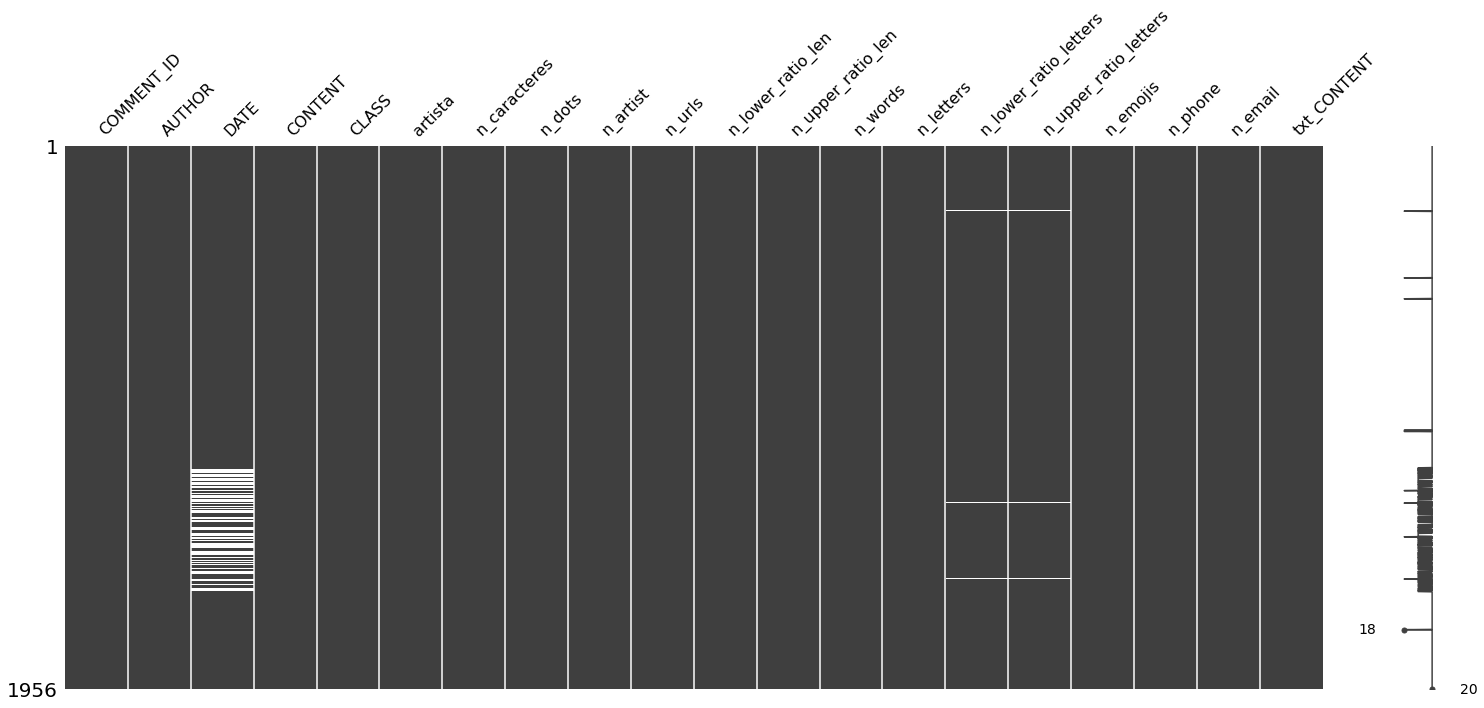

In [36]:
msno.matrix(data_spam)

In [37]:
X = data_spam[ls_features].fillna(0).join(pd.DataFrame(data = cv.transform(data_spam["txt_CONTENT"]).todense(), columns = cv.get_feature_names()))
y = data_spam["CLASS"]

In [38]:
X

,n_caracteres,n_dots,n_artist,n_urls,n_lower_ratio_len,n_upper_ratio_len,n_words,n_letters,n_lower_ratio_letters,n_upper_ratio_letters,...,way,website,working,world,would,www,year,years,youtube,zonepa
0,126,3,0,1,0.642857,0.119048,20,96,0.843750,0.156250,...,0.0,0.0,0.0,0.0,0.000000,0.349845,0.0,0.0,0.0,0.0
1,159,13,0,1,0.647799,0.037736,10,109,0.944954,0.055046,...,0.0,0.0,0.0,0.0,0.000000,0.337444,0.0,0.0,0.0,0.0
2,340,4,0,1,0.770588,0.020588,55,269,0.973978,0.026022,...,0.0,0.0,0.0,0.0,0.328578,0.292097,0.0,0.0,0.0,0.0
3,52,1,0,1,0.653846,0.057692,5,37,0.918919,0.081081,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,80,2,0,1,0.625000,0.087500,7,57,0.877193,0.122807,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,74,0,0,0,0.702703,0.054054,15,56,0.928571,0.071429,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1952,42,0,0,0,0.595238,0.047619,9,27,0.925926,0.074074,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1953,67,0,0,0,0.731343,0.014925,13,50,0.980000,0.020000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1954,128,6,0,1,0.812500,0.000000,10,104,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [39]:
X.shape

(1956, 113)

In [40]:
kb = SelectKBest(k=10, score_func=f_classif)

In [41]:
kb.fit(X, y)

/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [12] are constant.
  UserWarning)
/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest()

In [42]:
ls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]

In [43]:
kb.get_support()

array([ True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False])

In [44]:
ls_best

['n_caracteres',
 'n_words',
 'n_letters',
 'channel',
 'check',
 'com',
 'please',
 'song',
 'subscribe',
 'youtube']

In [45]:
X = X[ls_best]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
logreg = LogisticRegression()

In [48]:
logreg.fit(X_train, y_train,)

/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [49]:
logreg.score(X_test, y_test)

0.9202453987730062

In [53]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,f1_score

In [50]:
def metricas(model,Xv,yv): #Mide efectividad de un Modelo Predictivo
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

In [51]:
metricas(logreg,X_test, y_test)

 Roc Validate: 0.959
 Acc Validate: 0.920
 Matrix Conf Validate:  
 [[219  13]
 [ 26 231]]


In [54]:
f1_score(y_test,logreg.predict(X_test))

0.9221556886227544

In [55]:
f1_score(y_test,logreg.predict(X_test),pos_label=0)

0.9182389937106918

In [58]:
metricas(bayes,X_test, y_test)

 Roc Validate: 0.843
 Acc Validate: 0.759
 Matrix Conf Validate:  
 [[164  64]
 [ 54 207]]


In [61]:
os.listdir('/home/jorge/nltk_data/corpora/stopwords/')

['russian',
 'dutch',
 'README',
 'french',
 'english',
 'norwegian',
 'greek',
 'italian',
 'finnish',
 'azerbaijani',
 'indonesian',
 'romanian',
 'turkish',
 'danish',
 'german',
 'nepali',
 'portuguese',
 'kazakh',
 'hungarian',
 'arabic',
 'spanish',
 'swedish']